# Práctica 2 - Parte 4: Robot móvil en el plano

En esta parte de la práctica se estudiará el modelo cinemático de un robot móvil de tipo diferencial. El objetivo es representar la evolución de su trayectoria en el plano XY, mostrar su orientación con una flecha y diseñar una ley de control para alcanzar un objetivo (goal).

---

## Enunciado general

1. Implementa en Python el modelo cinemático de un robot móvil en el plano:
   $
   \dot{x} = v \cos \theta, \quad
   \dot{y} = v \sin \theta, \quad
   \dot{\theta} = \omega
   $
   donde $u(t) = (v, \omega)$ son las entradas de control (velocidad lineal y angular).

2. Simula la evolución del robot para una entrada constante $u(t)$, de modo que la trayectoria sea circular.

3. Representa gráficamente la posición $(x,y)$ del robot en el plano y su orientación con una flecha. Añade también un punto de color distinto que represente el objetivo (goal) en el plano.

4. Implementa una ley de control para llevar al robot a una pose deseada $(x_d, y_d, \theta_d)$ y verifica el resultado.

5. Repite el proceso para distintos objetivos y compara los resultados.

---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as widgets

## Ejercicio 1

Simula el modelo del robot móvil con entradas constantes $v$ y $\omega$ y representa su trayectoria en el plano XY.
Muestra también su orientación con una flecha y dibuja un objetivo (goal) en el plano, que se pueda modificar de manera interactiva.

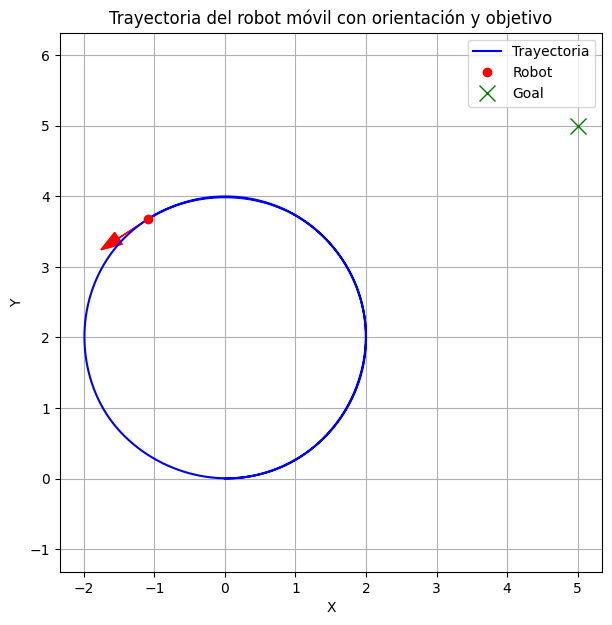

In [2]:
# Modelo del robot móvil
def robot_model(t, state, v, omega):
    x, y, theta = state
    dxdt = v * np.cos(theta)
    dydt = v * np.sin(theta)
    dthetadt = omega
    return [dxdt, dydt, dthetadt]

# Parámetros iniciales
state0 = [0, 0, 0]  # (x0, y0, theta0)
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Entradas constantes para movimiento circular
v = 1.0
omega = 0.5

# Simulación
sol = solve_ivp(robot_model, t_span, state0, t_eval=t_eval, args=(v, omega))

# Función de representación con goal
def plot_robot_with_goal(x, y, theta, goal=(5,5)):
    plt.figure(figsize=(7,7))
    plt.plot(sol.y[0], sol.y[1], 'b-', label="Trayectoria")
    plt.plot(x, y, 'ro', label="Robot")
    plt.arrow(x, y, 0.5*np.cos(theta), 0.5*np.sin(theta), head_width=0.2, color='r')
    plt.plot(goal[0], goal[1], 'gx', markersize=12, label="Goal")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Trayectoria del robot móvil con orientación y objetivo")
    plt.legend()
    plt.axis("equal")
    plt.grid(True)
    plt.show()

# Ejemplo de visualización con goal (5,5)
plot_robot_with_goal(sol.y[0][-1], sol.y[1][-1], sol.y[2][-1], goal=(5,5))

## Ejercicio 2

Implementa una **ley de control** que lleve al robot desde su estado inicial $x(0) = (0,0,0)$ hasta una pose deseada $goal = (x_d, y_d, \theta_d)$.
Simula el comportamiento y representa gráficamente los resultados como en el ejemplo anterior. Incluye interacción con $(x_d, y_d, \theta_d)$.

In [3]:
# Ejercicio 2: control de pose (unicycle / robot diferencial)
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def closed_loop_dynamics(t, state, goal, gains, v_max=1.5, omega_max=2.0):
    x, y, theta = state
    x_d, y_d, theta_d = goal
    k_rho, k_alpha, k_beta = gains
    dx = x_d - x
    dy = y_d - y
    rho = np.hypot(dx, dy)
    alpha = wrap_angle(np.arctan2(dy, dx) - theta)
    beta = wrap_angle(theta_d - theta - alpha)

    v = k_rho * rho
    omega = k_alpha * alpha + k_beta * beta

    v = np.clip(v, -v_max, v_max)
    omega = np.clip(omega, -omega_max, omega_max)

    dxdt = v * np.cos(theta)
    dydt = v * np.sin(theta)
    dthetadt = omega
    return [dxdt, dydt, dthetadt]

def simulate_to_goal(goal=(5, 5, 0), gains=(1.0, 3.0, -1.0), t_end=20.0, n=600):
    t_eval = np.linspace(0, t_end, n)
    sol = solve_ivp(
        closed_loop_dynamics,
        (0, t_end),
        state0,
        t_eval=t_eval,
        args=(goal, gains),
    )
    return sol

def run_control(x_d=5.0, y_d=5.0, theta_d=0.0, k_rho=1.0, k_alpha=3.0, k_beta=-1.0):
    goal = (x_d, y_d, theta_d)
    gains = (k_rho, k_alpha, k_beta)
    sol = simulate_to_goal(goal=goal, gains=gains)
    x, y, theta = sol.y

    # Controles y errores para visualizar
    v_list = []
    omega_list = []
    rho_list = []
    alpha_list = []
    beta_list = []
    for xi, yi, ti in zip(x, y, theta):
        dx = x_d - xi
        dy = y_d - yi
        rho = np.hypot(dx, dy)
        alpha = wrap_angle(np.arctan2(dy, dx) - ti)
        beta = wrap_angle(theta_d - ti - alpha)
        v = k_rho * rho
        omega = k_alpha * alpha + k_beta * beta
        v_list.append(v)
        omega_list.append(omega)
        rho_list.append(rho)
        alpha_list.append(alpha)
        beta_list.append(beta)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, y, 'b-', label='Trayectoria')
    plt.plot(x[0], y[0], 'ko', label='Inicio')
    plt.plot(x[-1], y[-1], 'ro', label='Final')
    plt.plot(x_d, y_d, 'gx', markersize=12, label='Goal')
    plt.arrow(x[-1], y[-1], 0.5*np.cos(theta[-1]), 0.5*np.sin(theta[-1]),
              head_width=0.2, color='r')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Trayectoria con ley de control")
    plt.axis("equal")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(sol.t, rho_list, label=r"$\rho$ (distancia)")
    plt.plot(sol.t, alpha_list, label=r"$\alpha$ (orientación)")
    plt.plot(sol.t, beta_list, label=r"$\beta$ (orientación final)")
    plt.xlabel("t")
    plt.title("Errores de pose")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

widgets.interact(
    run_control,
    x_d=widgets.FloatSlider(value=5, min=-10, max=10, step=0.5, description='x_d'),
    y_d=widgets.FloatSlider(value=5, min=-10, max=10, step=0.5, description='y_d'),
    theta_d=widgets.FloatSlider(value=0, min=-np.pi, max=np.pi, step=0.1, description='theta_d'),
    k_rho=widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='k_rho'),
    k_alpha=widgets.FloatSlider(value=3.0, min=0.5, max=5.0, step=0.1, description='k_alpha'),
    k_beta=widgets.FloatSlider(value=-1.0, min=-5.0, max=-0.1, step=0.1, description='k_beta'),
)

interactive(children=(FloatSlider(value=5.0, description='x_d', max=10.0, min=-10.0, step=0.5), FloatSlider(va…

<function __main__.run_control(x_d=5.0, y_d=5.0, theta_d=0.0, k_rho=1.0, k_alpha=3.0, k_beta=-1.0)>

## Preguntas de reflexión

1. **¿Qué diferencias se observan entre el movimiento circular con $u=(v,\omega)$ constante y el movimiento con ley de control?**  
   Con $v$ y $\omega$ constantes el robot describe una trayectoria fija (normalmente un círculo o una curva periódica) y no “corrige” su rumbo. Con la ley de control, en cambio, el robot ajusta continuamente su velocidad y su giro según el error de posición y orientación, por lo que la trayectoria se adapta para llegar al objetivo y se observa convergencia a la pose deseada.

2. **¿Cómo influye la elección de las ganancias en la ley de control ($k_\rho, k_\alpha, k_\beta$) en el comportamiento del robot?**  
   - $k_\rho$ controla cuánto “empuja” el robot hacia el objetivo: valores altos aceleran la llegada pero pueden causar oscilaciones.  
   - $k_\alpha$ ajusta la rapidez con la que el robot corrige su orientación hacia el objetivo: si es bajo, gira lento; si es alto, puede girar demasiado brusco.  
   - $k_\beta$ corrige la orientación final en la pose deseada. Un valor negativo ayuda a estabilizar la orientación final.  
   En general, ganancias muy pequeñas hacen al sistema lento y ganancias muy grandes pueden generar sobrepasos o trayectorias nerviosas.

3. **¿Por qué cambia la trayectoria si solamente modificamos $\theta_d$?**  
   Aunque la posición final $(x_d, y_d)$ sea la misma, el robot debe llegar con una orientación específica. Para cumplir esa orientación, la ley de control cambia la manera en que se aproxima al punto, lo que puede producir trayectorias distintas (por ejemplo, rodeos o giros antes de llegar).

4. **¿Qué ocurre si el objetivo (goal) se sitúa muy lejos? ¿Y si está muy cerca?**  
   Si el objetivo está lejos, el robot tiende a avanzar más rápido (porque $\rho$ es grande) y la trayectoria suele ser más suave. Si está muy cerca, el control se vuelve más sensible a pequeñas variaciones de orientación y puede haber maniobras de corrección más visibles (giro en el lugar o pequeñas oscilaciones).

5. **¿Cómo se relaciona este ejemplo con los conceptos de controlabilidad y estabilidad vistos en teoría?**  
   La ley de control muestra que el sistema es **controlable**: mediante $v$ y $\omega$ se puede llevar el estado a una pose deseada. Además, la convergencia de los errores $(\rho, \alpha, \beta)$ a cero ilustra la **estabilidad** del sistema bajo la ley de control (cuando las ganancias se eligen adecuadamente).
